# Task #2

A template code for training an RBM on Rydberg atom data (the full dataset) is provided below. For the first part of this task (determining the minimum number of hidden units), start with 1 hidden units. 

Imports and loadining in data:

In [1]:
import numpy as np
import torch
from RBM_helper import RBM
from tqdm import tqdm
import matplotlib.pyplot as plt
import Rydberg_energy_calculator

training_data = torch.from_numpy(np.loadtxt("Rydberg_data.txt"))

Define the RBM:

In [2]:
def train_rbm(training_data,epochs,num_samples,n_vis,n_hin,N_draws=1000):
    '''
        Train a restricted Boltzmann Machine 
        
        Args:
            training_data: 
            epochs:
            num_samples:
            N_draws:
        Returns:
            Array: An N_draw array containing the energies  
    '''
    
    # Instantiate the RBM
    rbm = RBM(n_vis, n_hin)
    
    # Carry out the training over the defined number of epochs
    for e in range(1, epochs+1):
        # do one epoch of training
        rbm.train(training_data)   

    E_samples = np.zeros(N_draws)
    
    for k in tqdm(range(0,N_draws)):
        init_state = torch.zeros(num_samples, n_vis)
        RBM_samples = rbm.draw_samples(100, init_state)
        energies = Rydberg_energy_calculator.energy(RBM_samples, rbm.wavefunction)
        E_samples[k] = energies.item()
    
    
    return E_samples

def confidence_interval(x):
    '''
    
        Compute the 68% and 96% confidence inteval of a data set
        
        Args:
            x: numpy array
        Returns:
            Tuple: array1,array2
            
            where array1 and array2 are each numpy arrays of length=3
            array1 = [lower_68%_bound, median , upper_68%_bound]
            array2 = [lower_96%_bound, median , upper_96%_bound]
    '''
    x_68 = np.percentile(x, [16,50,84])
    x_96 = np.percentile(x, [2,50,98])
    
    return x_68,x_96

# Training the RBM as a function of the number of hidden layers

In [4]:
epochs = 1000
num_samples = training_data.shape[0]
exact_energy = -4.1203519096
tol = 3*1e-4 # The desired tolerance level
n_hid_max=20
N_draws =50 # The number of samples to draw at the end for statistics 

n_hidden_array = []
E_68_nhidden = []
E_96_nhidden = []

for nk in range(1,n_hid_max,2):
    n_hidden_array.append(nk)
    n_training_data = training_data.shape[1]
    n_hin = nk
    E_samples = train_rbm(training_data,epochs,n_vis=n_training_data,n_hin=n_hin,num_samples=num_samples,N_draws=N_draws)
    E_68,E_96 = confidence_interval(E_samples)
    E_68_nhidden.append(E_68)
    E_96_nhidden.append(E_96)
    print(nk,E_68[1],exact_energy, abs(E_68[1]-exact_energy))

100%|██████████| 50/50 [04:01<00:00,  4.68s/it]


1 -4.1200725022710065 -4.1203519096 0.0002794073289935639


100%|██████████| 50/50 [04:04<00:00,  4.85s/it]


3 -4.120058106791608 -4.1203519096 0.0002938028083923072


100%|██████████| 50/50 [04:06<00:00,  4.93s/it]


5 -4.1200725338773925 -4.1203519096 0.000279375722607611


100%|██████████| 50/50 [04:14<00:00,  5.21s/it]


7 -4.120040983066661 -4.1203519096 0.0003109265333387512


100%|██████████| 50/50 [04:14<00:00,  5.15s/it]


9 -4.120017817277636 -4.1203519096 0.0003340923223644765


100%|██████████| 50/50 [04:22<00:00,  5.27s/it]


11 -4.120015918484322 -4.1203519096 0.0003359911156781692


100%|██████████| 50/50 [04:23<00:00,  5.21s/it]


13 -4.119973185989552 -4.1203519096 0.0003787236104484393


100%|██████████| 50/50 [04:28<00:00,  5.37s/it]


15 -4.11998591497831 -4.1203519096 0.00036599462169029096


100%|██████████| 50/50 [04:37<00:00,  5.39s/it]


17 -4.119942775906857 -4.1203519096 0.00040913369314310444


100%|██████████| 50/50 [04:40<00:00,  5.49s/it]

19 -4.11988223783707 -4.1203519096 0.0004696717629304459


In [5]:
# Preprocess the results in order to generate the plot

E_96_nhidden = np.array(E_96_nhidden)
E_68_nhidden = np.array(E_68_nhidden)

delta_E_med =  abs(E_96_nhidden[:,1]-exact_energy) #/tol
delta_E_lower_68 =  abs(E_68_nhidden[:,0]-exact_energy)#/tol
delta_E_upper_68 =  abs(E_68_nhidden[:,2]-exact_energy)#/tol
delta_E_lower_96 =  abs(E_96_nhidden[:,0]-exact_energy)#/tol
delta_E_upper_96 =  abs(E_96_nhidden[:,2]-exact_energy)#/tol

# Determine the number of hidden nodes required for uncertainty band to overlap tolerance level
n_hidden_tol_indx = np.argmin(delta_E_med)
n_hidden_tol = n_hidden_array[n_hidden_tol_indx]


print('='*100)
print('The minimum number of hidden units to reach tolerance level is: ',n_hidden_tol)
print('='*100)

The minimum number of hidden units to reach tolerance level is:  5


We now plot the achieved tolerance of the RBM as a function of the number of hidden units.

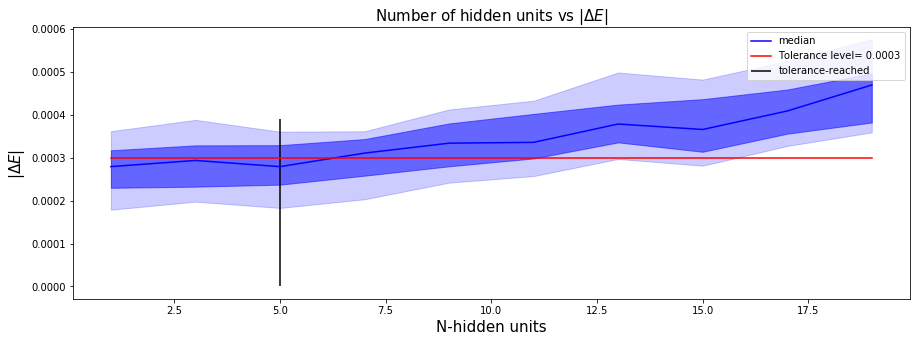

In [46]:
plt.figure(figsize=(15,5))
plt.title(r'Number of hidden units vs $|\Delta E |$',size=15)
plt.plot(n_hidden_array,delta_E_med,label='median',color='blue')
plt.fill_between(n_hidden_array,delta_E_lower_68, delta_E_upper_68,color='blue',alpha='0.5',edgecolor='b')
plt.fill_between(n_hidden_array,delta_E_lower_96, delta_E_upper_96,color='blue',alpha='0.2',edgecolor='b')
plt.plot(n_hidden_array,tol*np.ones(len(n_hidden_array)),label='Tolerance level= '+str(round(tol,5)),color='r')
plt.vlines( n_hidden_array[n_hidden_tol_indx],ymin=0,ymax=tol*1.3,label='tolerance-reached')
plt.xlabel('N-hidden units',size=15)
plt.ylabel(r'$|\Delta E|$ ',size=15)
plt.legend()
plt.show()

From the above plot, we find that a reasonable tolerance level for the algorithm is tol=$3 \cdot 10^{-4}$. We have also drawn several samples from the final trained RBM in order to plot the 68% confidence bands in darker blue and the 96% confidence bands in lighter blue.   

At this level of tolerance, the best number of hidden units required to remain below the tolerance level was $n_{\rm hidden }=5$. 

# Training the RBM as a function of the amount of data

In the next blocks we keep the number of hidden layers fixed using the value we found in the previous blocks and vary the amount of data that we use for training. 

In [29]:
epochs = 1000
num_samples = training_data.shape[0]
exact_energy = -4.1203519096
N_draws =50 # The number of samples to draw at the end 

n_samples_array = []
E_68_nsamples = []
E_96_nsamples = []

for nk in range(500,training_data.shape[0],2500):
    n_samples_array.append(nk)
    n_training_data = training_data.shape[1]
    n_hin = n_hidden_tol # The optimal number of hidden layers
    E_samples = train_rbm(training_data,epochs,n_vis=n_training_data,n_hin=n_hin,num_samples=nk,N_draws=N_draws)
    E_68,E_96 = confidence_interval(E_samples)
    E_68_nsamples.append(E_68)
    E_96_nsamples.append(E_96)

100%|██████████| 50/50 [03:57<00:00,  4.53s/it]


In [40]:
E_96_nsamples = np.array(E_96_nsamples)
E_68_nsamples= np.array(E_68_nsamples)

ddelta_E_med =  abs(E_68_nsamples[:,1]-exact_energy)
ddelta_E_lower_68 =  abs(E_68_nsamples[:,0]-exact_energy)
ddelta_E_upper_68 =  abs(E_68_nsamples[:,2]-exact_energy)
ddelta_E_lower_96 =  abs(E_96_nsamples[:,0]-exact_energy)
ddelta_E_upper_96 =  abs(E_96_nsamples[:,2]-exact_energy)

Finally we plot the median values of the achieved tolerance levels with the 68% and 96% confidence intervals.

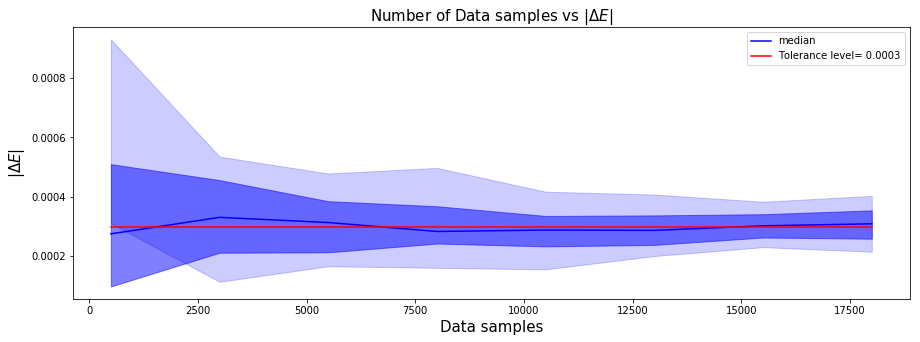

In [45]:
plt.figure(figsize=(15,5))
plt.title(r'Number of Data samples vs $|\Delta E |$',size=15)
plt.plot(n_samples_array,ddelta_E_med,label='median',color='blue')
plt.fill_between(n_samples_array,ddelta_E_lower_68, ddelta_E_upper_68,color='blue',alpha='0.5',edgecolor='b')
plt.fill_between(n_samples_array,ddelta_E_lower_96, ddelta_E_upper_96,color='blue',alpha='0.2',edgecolor='b')
plt.plot(n_samples_array,tol*np.ones(len(n_samples_array)),label='Tolerance level= '+str(round(tol,5)),color='red')
plt.xlabel('Data samples',size=15)
plt.ylabel(r'$|\Delta E|$',size=15)
plt.legend()
plt.show()


From the above plot, we see that as the amount of training data increases, the variance of th results decreases.
The median of the achieved tolerance level remains about the same for all calculations. To achieve the 
minimum variance/ amount of data samples, we need approximately $N_{\rm data}= 15,000$ training samples.